##### Copyright 2018 The TensorFlow Constrained Optimization Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Overview

In this notebook, we will compare two different ways to use minibatches to solve a rate-constrained training problem. We will consider a classification problem, where there is a fairness constraint on a small subset of examples, deemed as the *protected group*. For this task, we will first train a classifier by dividing the entire training set into fixed size minibatches and performing gradient updates on each minibatch. We will then show how to speed up the convergence of the optimizer by using two data streams, with one exclusively for the protected group.

We start by importing the relevant modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from six.moves import xrange
from sklearn import model_selection
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

# Tensorflow constrained optimization library
import tensorflow_constrained_optimization as tfco

## Communities and Crimes

We will use the benchmark *Communities and Crimes* dataset from the UCI Machine Learning repository for our illustration. This dataset contains various demographic and racial distribution details (aggregated from census and law enforcement data sources) about different communities in the US, along with the per capita crime rate in each commmunity. 
As is commonly done in the literature, we will bin the crime rate attribute into two categories: "low crime" and "high crime", and formulate the task of predicting whether a community has a low crime rate or a high crime rate.

A popular fairness goal for this dataset is that the performance of the learned classifier is similar across communities with different race distributions. As an example fairness constraint, we will treat communities where the percentage of black population is above a certain threshold as a protected group, and constrain the false negative rate (FNR) of the learned classifier for this group to be similar to the overall false negative rate (specifically, we will constrain the difference between the FNR for the protected group and the overall FNR to be at most 0.01).

We begin by downloading and preprocessing the dataset.

In [2]:
# List of column names in the dataset.
column_names = ["state", "county", "community", "communityname", "fold", "population", "householdsize", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par", "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell", "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant", "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ", "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState", "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens", "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"]

In [3]:
dataset_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

# Read dataset from the UCI web repository and assign column names.
data_df = pd.read_csv(dataset_url, sep=",", names=column_names,
                      na_values="?")
data_df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


For our illustration, we will need the label and group proportions to be imbalanced (i.e. the high crime communities to be far fewer in number than the low crime ones, and the communities marked as protected to be far fewer than those that are not). We will make the label and group assignments accordingly.

The 'ViolentCrimesPerPop' column contains the per capita crime rate for each community. We label the communities with a crime rate above the 95-th percentile as 'high crime' and the others as 'low crime'. These would serve as our target labels for binary classification.

In [4]:
# Make sure that there are no missing values in the "ViolentCrimesPerPop" column.
assert(not data_df["ViolentCrimesPerPop"].isna().any())

# Binarize the "ViolentCrimesPerPop" column and obtain labels.
crime_rate_95_percentile = data_df["ViolentCrimesPerPop"].quantile(q=0.95)
labels_df = (data_df["ViolentCrimesPerPop"] >= crime_rate_95_percentile)

# Now that we have assigned binary labels, 
# we drop the "ViolentCrimesPerPop" column from the data frame.
data_df.drop(columns="ViolentCrimesPerPop", inplace=True)

We next identify communities where the percentage of black population is above the 95-th percentile and term them as the protected group. This grouping would be used to impose fairness constraints during training. 

In [5]:
# Make sure that there are no no missing values in the "racepctblack" column.
assert(not data_df["racepctblack"].isna().any())

# Binarize the "racepctblack" column and create protected groups.
race_black_95_percentile = data_df["racepctblack"].quantile(q=0.95)
groups_df = (data_df["racepctblack"] >= race_black_95_percentile)

# We do not drop the "racepctblack" column, as we would include it 
# as a feature for prediction.

All that remains is to pick the features. We drop all categorical columns, and use the numerical columns as features for prediction.

In [6]:
data_df.drop(columns=["state", "county", "community", "communityname", "fold"],
             inplace=True)

Some of the numerical columns contain missing values (denoted by a NaN). For each feature that has at least one value missing, we append an additional boolean "is_missing" feature indicating that the value was missing, and fill the missing value with 0.

In [7]:
feature_names = data_df.columns
for feature_name in feature_names:  
    missing_rows = data_df[feature_name].isna()  # Which rows have missing values?
    if missing_rows.any():  # Check if at least one row has a missing value.
        data_df[feature_name].fillna(0.0, inplace=True)  # Fill NaN with 0.
        missing_rows.rename(feature_name + "_is_missing", inplace=True)
        data_df = data_df.join(missing_rows)  # Append boolean "is_missing" feature.

We thus have the labels, protected group indicators and features to set up our training problem.

In [8]:
labels = labels_df.values.astype(np.float32)
groups = groups_df.values.astype(np.float32)
features = data_df.values.astype(np.float32)

Finally, we divide the dataset randomly into two-thirds for training and one-thirds for testing.

In [9]:
# Set random seed so that the results are reproducible.
np.random.seed(123456)

# Train and test indices.
train_indices, test_indices = model_selection.train_test_split(
    xrange(features.shape[0]), test_size=1./3.)

# Train features, labels and protected groups.
x_train = features[train_indices, :]
y_train = labels[train_indices]
z_train = groups[train_indices]

# Test features, labels and protected groups.
x_test = features[test_indices, :]
y_test = labels[test_indices]
z_test = groups[test_indices]

## Minibatch Training with a Single Stream

Having processed the data, we will now formulate our fairness-constrained training problem. To solve this problem, we will first implement the standard minibatching strategy of dividing the entire training set into fixed size minibatches and performing gradient updates on each minibatch.

We will work with a linear classification model and define the data and model tensors. Note that we use placeholder tensors for the labels, groups indicators and features so that we can later feed in the contents from a minibatch to these tensors.

In [10]:
num_examples, dimension = x_train.shape

# Reset TF graph.
tf.reset_default_graph() 

# Create variables containing the model parameters.
weights = tf.Variable(tf.zeros(dimension), dtype=tf.float32, name="weights")
threshold = tf.Variable(0.0, dtype=tf.float32, name="threshold")

# Create tensors for data and predictions.
labels_tensor = tf.placeholder(tf.float32, shape=(None,), name="labels")
groups_tensor = tf.placeholder(tf.float32, shape=(None,), name="groups")
features_tensor = tf.placeholder(tf.float32, shape=(None, dimension), name="features")
predictions_tensor = tf.tensordot(features_tensor, weights, axes=(1, 0)) - threshold

The fairness constraint that we wish to impose is that the FNR of the trained model for the communities marked as protected is different from the overall FNR by at most 0.01. To impose this constraint, we will need to define two contexts: one for overall FNR and the other for the protected group FNR. The first context is defined using the `tfco.rate_context` function. The second context is obtained using the `context.subset` function by providing a boolean predicate indicating which communities belong to the protected group.

In [11]:
# Create context for overall dataset, and for the protected group examples.
context = tfco.rate_context(predictions_tensor, labels=labels_tensor)
context_protected = context.subset(groups_tensor > 0)
# Note that we will not be able to use an equality condition
# of the form groups_tensor == 1 for the predicate, as this will
# check if two Tensor objects are the same, instead of checking 
# whether the elements of a tensor equals 1.

We then set up the rate-constrained minimization problem. The goal is to optimize the overall error rate subject to fairness constraints. The error rate is defined on the overall context and is approximated during training using the hinge loss (the default option). We use the proxy-Lagrangian optimizer for solving the constrained optimization problem, with Adagrad as the inner optimizer. We set the learning rate for updates to the model parameters to 1 and the learning rate for updates to the internal Lagrange multiplier parameters to 0.5 (among the different learning rates we experimented with, we found these choices to yield the best convergence behavior).

In [12]:
# Set up rate-constrained minimization problem.
problem = tfco.RateMinimizationProblem(
    tfco.error_rate(context), 
    [tfco.false_negative_rate(context_protected) <= tfco.false_negative_rate(context) + 0.01,
     tfco.false_negative_rate(context_protected) >= tfco.false_negative_rate(context) - 0.01])

# Set up optimizer.
optimizer = tfco.ProxyLagrangianOptimizerV1(
    optimizer=tf.train.AdagradOptimizer(learning_rate=1.0),
    constraint_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5)
)
train_op = optimizer.minimize(problem)

Before proceeding to solving the training problem, we write a couple of helper functions to evaluate the performance of the learned classifier.

In [13]:
def average_hinge_loss(labels, predictions):
    # Returns the average hinge loss for given labels and predictions.
    # Recall that the labels are binary (0 or 1).
    signed_labels = (labels * 2) - 1
    return np.mean(np.maximum(0.0, 1.0 - signed_labels * predictions))

def false_negative_rate(labels, predictions):
    # Returns the false negative rate for given labels and predictions.
    # Calculate fraction of positive examples that were classified as negative.
    pos_predictions = predictions[labels > 0] 
    return np.mean(pos_predictions <= 0)

We are now ready to train our model. We divide the training set into small minibatches of size 32 and perform a total of 10000 gradient updates, making multiple passes over the training set. We maintain a counter for the minibatches, and based on the current counter, identify the window of indices in the training set to read from, and cycle back to the beginning whenever we reach the end of the training set.

In [14]:
# Total number of iterations.
num_iterations = 10000

# Set up counter for minibatch stream.
batch_size = 32
num_batches = int(num_examples / batch_size)
batch_index = 0

# List of objective and constraint violations on training and test sets.
train_objectives = []
train_constraints = []
test_objectives = []
test_constraints = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Loop over minibatches.
    for ii in xrange(num_iterations):
        # Indices for the current minibatch.
        batch_indices = xrange(batch_index * batch_size, 
                               (batch_index + 1) * batch_size)
        # Cycle back to the beginning if we have reached the end of the training set.
        batch_indices = [ind % num_examples for ind in batch_indices]
        
        # Perform gradient update by feeding in the current minibatch.
        session.run(train_op, feed_dict={features_tensor: x_train[batch_indices, :],
                                         labels_tensor: y_train[batch_indices],
                                         groups_tensor: z_train[batch_indices]})
        
        # Obtain current weights and threshold.
        trained_weights, trained_threshold = session.run((weights, threshold))
        
        # Evaluate objective value and constraint violations on entire training set.
        predictions_train = np.matmul(x_train, trained_weights) - trained_threshold
        objective = average_hinge_loss(y_train, predictions_train)
        fnr_overall = false_negative_rate(y_train, predictions_train)
        fnr_protected = false_negative_rate(y_train[z_train == 1], 
                                            predictions_train[z_train == 1])
        
        train_objectives.append(objective)
        train_constraints.append([fnr_overall - fnr_protected - 0.01,
                                  fnr_protected - fnr_overall - 0.01])
        
        # Evaluate objective value and constraint violations on entire test set.
        predictions_test = np.matmul(x_test, trained_weights) - trained_threshold
        objective = average_hinge_loss(y_test, predictions_test)
        fnr_overall = false_negative_rate(y_test, predictions_test)
        fnr_protected = false_negative_rate(y_test[z_test == 1], 
                                            predictions_test[z_test == 1])
        test_objectives.append(objective)
        test_constraints.append([fnr_overall - fnr_protected - 0.01,
                                 fnr_protected - fnr_overall - 0.01])

        # Increment minibatch counter.
        batch_index += 1

Note that after each update, we record the current model's hinge loss objective and the current model's constraint violations on the entire training set (not the current minibatch) and the test set.

To analyze the convergence of the optimizer, we plot the cumulative means of the objective across iterations (i.e. for each $t$, we plot the average objective value across iterations $1, \ldots, t$). For the constraints, we plot the maximum of the cumulative means of the two constraint violations. Had we instead plotted the individual objective and constraint values at each iteration, we would have likely seen a lot of oscillations. Since we expect the iterates to converge on *average*, the cumulative means of the objective and constraints provide a better picture of the optimizer's convergence.

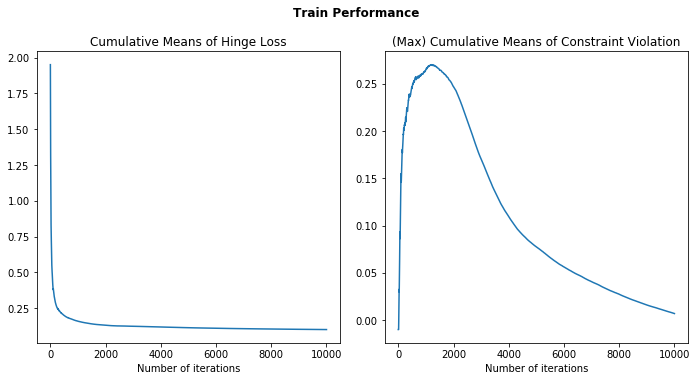

In [15]:
  # Plot objective and (max) constraint violation across minibatches.
ff, ax = plt.subplots(1, 2, figsize=(10, 5))
iteration_counts = range(1, num_iterations + 1)

# Plot of cumulative means of objective.
average_objectives = np.cumsum(train_objectives) / iteration_counts
ax[0].plot(iteration_counts, average_objectives)
ax[0].set_title("Cumulative Means of Hinge Loss")
ax[0].set_xlabel("Number of iterations")

# Plot of max cumulative means of contraint violations.
cum_mean1 = np.cumsum([x[0] for x in train_constraints]) / iteration_counts
cum_mean2 = np.cumsum([x[1] for x in train_constraints]) / iteration_counts
max_average_constraints = np.amax([cum_mean1, cum_mean2], axis=0)
ax[1].plot(iteration_counts,  max_average_constraints)
ax[1].set_title("(Max) Cumulative Means of Constraint Violation")
ax[1].set_xlabel("Number of iterations")

ff.suptitle("Train Performance", y=1.05, fontweight="bold")
ff.tight_layout()

Clearly, the (average) training objective converges to a small value, while the maximum (average) constraint violation approaches 0. Can we converge faster than this by using a different minibatching strategy?

## Minibatch Training with Multiple Streams

One of the factors that may slow down an optimizer for the present dataset is the severe imbalance in the label and group proportions. 

In [16]:
print("Proportion of protected group examples in training set = %.3f" 
      % np.mean(z_train == 1))
print("Proportion of positive protected group examples in training set = %.3f"
      % np.mean((z_train == 1) & (y_train == 1)))
print()
print("Number of protected group examples in training set = %d" 
      % np.sum(z_train == 1))
print("Number of positive protected group examples in training set = %d"
      % np.sum((z_train == 1) & (y_train == 1)))

Proportion of protected group examples in training set = 0.051
Proportion of positive protected group examples in training set = 0.018

Number of protected group examples in training set = 68
Number of positive protected group examples in training set = 24


With the previous minibatch implementation, only 5.1% of the examples in a minibatch are likely to come from the protected group, and only 1.8% of the examples in a minibatch are likely to be positive examples from the protected group. Therefore most minibatches are likely to yield poor estimates of FNR on the protected group. As a consequence, we will sometimes perform updates that are very small, and sometimes overcorrect with extremely large updates, leading to a slow convergence.

To avoid such noisy updates, we recommend using two streams of minibatches, with the first stream formed as before from the entire training set, and the second stream formed solely from the protected group examples. While defining the fairness constraints, we will compute the overall FNR using minibatches from the first stream and the protected group FNR using minibatches the second stream. By setting the batch size for the second stream to a reasonably large value, we expect our updates to be less noisy, and as a result, expect the optimizer to converge faster.

In [17]:
# Protected subset from train set.
x_train_protected = x_train[z_train == 1, :]
y_train_protected = y_train[z_train == 1]

# Protected subset from test set.
x_test_protected = x_test[z_test == 1, :]
y_test_protected = y_test[z_test == 1]

# Number of examples, dimension, 
# and number of protected examples in training set.
num_examples, dimension = x_train.shape
num_examples_protected = np.sum(z_train == 1)

Recall that with the earlier minibatching strategy, we needed to create just one context object and were able to use the `context.subset` method to subset the context and define rates on the protected group. With the new minibatching approach, we will have to define separate placeholder tensors to hold features and labels from the two streams. We will also have to maintain separate tensors for holding predictions for minibatches from the two streams (note that both prediction tensors need to be defined using the same model parameters).

In [18]:
# Reset existing TF computational graph.
tf.reset_default_graph() 

# Create variables containing the model parameters.
weights = tf.Variable(tf.zeros(dimension), dtype=tf.float32, name="weights")
threshold = tf.Variable(0.0, dtype=tf.float32, name="threshold")

# Create labels, features and predictions tensors for the entire dataset.
labels_tensor = tf.placeholder(tf.float32, shape=(None,), name="labels")
features_tensor = tf.placeholder(tf.float32, shape=(None, dimension), name="features")
predictions_tensor = tf.tensordot(features_tensor, weights, axes=(1, 0)) - threshold

# Create labels, features and predictions tensors for the protected group.
labels_tensor_protected = tf.placeholder(tf.float32, shape=(None,), name="labels_ptr")
features_tensor_protected = tf.placeholder(tf.float32, shape=(None, dimension), name="features_ptr")
predictions_tensor_protected = tf.tensordot(features_tensor_protected, 
                                            weights, axes=(1, 0)) - threshold

Having defined separate tensors for the two streams, we create two separate contexts for the two streams. We define a rate-constrained optimization problem in the same way as before, and set up the proxy-Lagrangian optimizer for solving it. Once again we set the inner optimizer to Adagrad with a learning rate of 1 for the model parameter updates and a learning rate of 0.5 for the Lagrange multiplier updates.

In [19]:
# Create context for overall dataset, and for the protected group examples.
context = tfco.rate_context(predictions_tensor, labels=labels_tensor)
context_protected = tfco.rate_context(predictions_tensor_protected, 
                                      labels=labels_tensor_protected)

# Set up rate-constrained minimization problem.
problem_two_streams = tfco.RateMinimizationProblem(
    tfco.error_rate(context),  
    [tfco.false_negative_rate(context_protected) <= tfco.false_negative_rate(context) + 0.01,
     tfco.false_negative_rate(context_protected) >= tfco.false_negative_rate(context) - 0.01])

# Set up optimizer.
optimizer_two_streams = tfco.ProxyLagrangianOptimizerV1(
    optimizer=tf.train.AdagradOptimizer(learning_rate=1.0),
    constraint_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5)
)
train_op_two_streams = optimizer_two_streams.minimize(problem_two_streams)

We are now ready to train our model. Since we had previously used a batch size of 32, for a fair comparison, we fix the effective number of examples seen per iteration from the two streams to also 32. We set the batch size for the first stream to 20 and for the second stream to 12 (contrast this with the previous implementation, where we received only 1 or 2 examples from the protected group per update). We once again perform 10000 minibatch updates.

We maintain a separate counter for each stream. Every time we perform a gradient update, we will have to pass the minibatch contents from the first stream to the placeholder tensors `features_tensor` and `labels_tensor`, and the minibatch contents from the second stream to the placeholder tensors `features_tensor_protected` and `labels_tensor_protected`.


In [20]:
# Total number of iterations.
num_iterations = 10000

# Set up counter for the first minibatch stream 
# (contains all examples in the training set).
batch_size = 20
batch_index = 0

# Set up counter for the second minibatch stream 
# (contains only the protected group examples in the training set).
batch_size_protected = 12
batch_index_protected = 0

# List of objective and constraint violations on training and test sets.
train_objectives_two_streams = []
train_constraints_two_streams = []
test_objectives_two_streams = []
test_constraints_two_streams = []

# Placeholder assignments for evaluating the training performance.
# Since this dictionary would be used in every iteration to evaluate the
# objective and contraint on the training set, we define it outside the 
# training iterations loop.
feed_dict_train = {
    features_tensor: x_train,
    labels_tensor: y_train,
    features_tensor_protected: x_train_protected,
    labels_tensor_protected: y_train_protected
}

# Placeholder assignements for evaluating the test performance.
# Since this dictionary would be used in every iteration to evaluate the
# objective and contraint on the test set, we define it outside the 
# training iterations loop.
feed_dict_test = {
    features_tensor: x_test,
    labels_tensor: y_test,
    features_tensor_protected: x_test_protected,
    labels_tensor_protected: y_test_protected
}

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Loop over minibatches.
    for ii in xrange(num_iterations):
        # Indices for current minibatch in the first stream.
        batch_indices = np.arange(batch_index * batch_size,
                                  (batch_index + 1) * batch_size)
        # Cycle back to the beginning if we have reached the end of the stream.
        batch_indices = [ind % num_examples for ind in batch_indices]
        
        # Indices for current minibatch in the second stream.
        batch_indices_protected = xrange(batch_index_protected * batch_size_protected, 
                                         (batch_index_protected + 1) * batch_size_protected)
        # Cycle back to the beginning if we have reached the end of the stream.
        batch_indices_protected = [ind % num_examples_protected 
                                   for ind in batch_indices_protected]
        
        # Perform gradient updates using minibatches from the two streams.
        feed_dict_batch = {
            # Stream 1 placeholders.
            features_tensor: x_train[batch_indices, :],
            labels_tensor: y_train[batch_indices],
            # Stream 2 placeholders.
            features_tensor_protected:x_train_protected[batch_indices_protected, :],
            labels_tensor_protected: y_train_protected[batch_indices_protected]
        }
        session.run(train_op_two_streams, feed_dict=feed_dict_batch)
        
        # Obtain current weights and threshold.
        trained_weights, trained_threshold = session.run((weights, threshold))
        
        # Evaluate objective value and constraint violations on entire training set.
        predictions_train = np.matmul(x_train, trained_weights) - trained_threshold
        objective = average_hinge_loss(y_train, predictions_train)
        fnr_overall = false_negative_rate(y_train, predictions_train)
        fnr_protected = false_negative_rate(y_train[z_train == 1], 
                                            predictions_train[z_train == 1])
        train_objectives_two_streams.append(objective)
        train_constraints_two_streams.append([fnr_overall - fnr_protected - 0.01,
                                              fnr_protected - fnr_overall - 0.01])
        
        # Evaluate objective value and constraint violations on entire test set.
        predictions_test = np.matmul(x_test, trained_weights) - trained_threshold
        objective = average_hinge_loss(y_test, predictions_test)
        fnr_overall = false_negative_rate(y_test, predictions_test)
        fnr_protected = false_negative_rate(y_test[z_test == 1], 
                                            predictions_test[z_test == 1])
        test_objectives_two_streams.append(objective)
        test_constraints_two_streams.append([fnr_overall - fnr_protected - 0.01,
                                             fnr_protected - fnr_overall - 0.01])

        # Increment minibatch counter for both streams.
        batch_index += 1
        batch_index_protected += 1 

We compare the cumulative means of the objective and constraint violations for the two stream approach with those for the single stream approach.

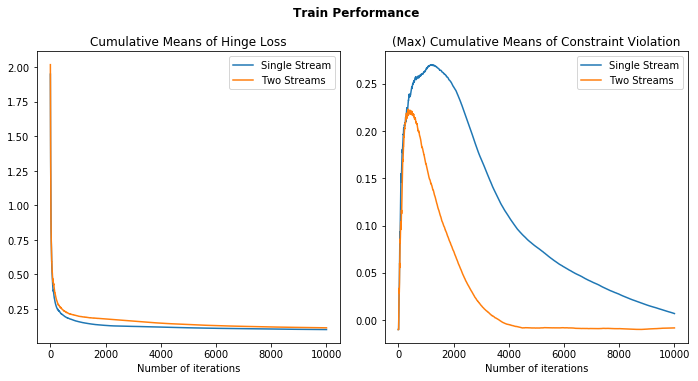

In [21]:
# Objective and constraint violation on train set.
ff, ax = plt.subplots(1, 2, figsize=(10, 5))
iteration_counts = range(1, num_iterations + 1)

# Plot of cumulative means of objective.
average_objectives = np.cumsum(train_objectives) / iteration_counts
ax[0].plot(iteration_counts, average_objectives, label="Single Stream")
average_objectives_two_streams = np.cumsum(train_objectives_two_streams) / iteration_counts
ax[0].plot(iteration_counts, average_objectives_two_streams, label="Two Streams")
ax[0].set_title("Cumulative Means of Hinge Loss")
ax[0].set_xlabel("Number of iterations")
ax[0].legend()

# Plot of max cumulative means of contraint violations.
cum_mean1 = np.cumsum([x[0] for x in train_constraints]) / iteration_counts
cum_mean2 = np.cumsum([x[1] for x in train_constraints]) / iteration_counts
max_average_constraints = np.amax([cum_mean1, cum_mean2], axis=0)
ax[1].plot(iteration_counts,  max_average_constraints, label="Single Stream")
cum_mean1 = np.cumsum([x[0] for x in train_constraints_two_streams]) / iteration_counts
cum_mean2 = np.cumsum([x[1] for x in train_constraints_two_streams]) / iteration_counts
max_average_constraints_two_streams = np.amax([cum_mean1, cum_mean2], axis=0)
ax[1].plot(iteration_counts,  max_average_constraints_two_streams, label="Two Streams")
ax[1].set_title("(Max) Cumulative Means of Constraint Violation")
ax[1].set_xlabel("Number of iterations")
ax[1].legend()

ff.suptitle("Train Performance", y=1.05, fontweight="bold")
ff.tight_layout()

By using two data streams, we are able to achieve lower constraint violations in far fewer iterations, while converging to the same objective value in half as many iterations. 

A similar pattern is also seen with the performance on the test set. However, in this case, both minibatching strategies end up with some residual constraint violations.

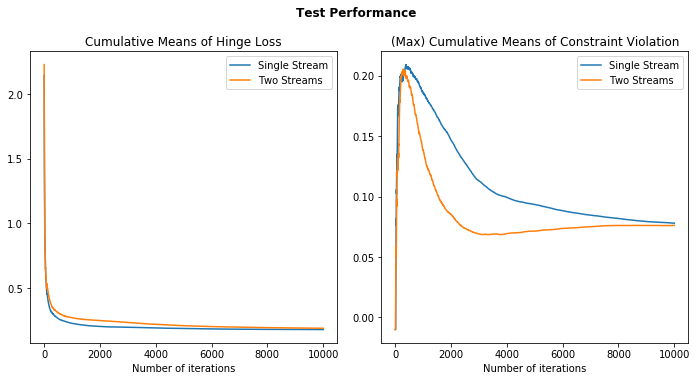

In [22]:
# Objective and constraint violation on test set.
ff, ax = plt.subplots(1, 2, figsize=(10, 5))
iteration_counts = range(1, num_iterations + 1)

# Plot of cumulative means of objective.
average_objectives = np.cumsum(test_objectives) / iteration_counts
ax[0].plot(iteration_counts, average_objectives, label="Single Stream")
average_objectives_two_streams = np.cumsum(test_objectives_two_streams) / iteration_counts
ax[0].plot(iteration_counts, average_objectives_two_streams, label="Two Streams")
ax[0].set_title("Cumulative Means of Hinge Loss")
ax[0].set_xlabel("Number of iterations")
ax[0].legend()

# Plot of max cumulative means of contraint violations.
cum_mean1 = np.cumsum([x[0] for x in test_constraints]) / iteration_counts
cum_mean2 = np.cumsum([x[1] for x in test_constraints]) / iteration_counts
max_average_constraints = np.amax([cum_mean1, cum_mean2], axis=0)
ax[1].plot(iteration_counts,  max_average_constraints, label="Single Stream")
cum_mean1 = np.cumsum([x[0] for x in test_constraints_two_streams]) / iteration_counts
cum_mean2 = np.cumsum([x[1] for x in test_constraints_two_streams]) / iteration_counts
max_average_constraints_two_streams = np.amax([cum_mean1, cum_mean2], axis=0)
ax[1].plot(iteration_counts,  max_average_constraints_two_streams, label="Two Streams")
ax[1].set_title("(Max) Cumulative Means of Constraint Violation")
ax[1].set_xlabel("Number of iterations")
ax[1].legend()

ff.suptitle("Test Performance", y=1.05, fontweight="bold")
ff.tight_layout()

## Conclusion

Training with a single data stream is convenient (particularly with the context subsetting functionality provided by the constrained optimization library), but can result in slow convergence for datasets with imbalanced group proportions. If one seeks to impose rate constraints on small groups of examples and wishes to use minibatches of small size, then it is often better to create separate minibatch streams for each group, rather than working with a single data stream and subsetting the relevant groups from the individual minibatches.